In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/hate_speech/models

/content/drive/MyDrive/hate_speech/models


In [3]:
! pip install transformers==4.25.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.4 MB/s eta 0:00:00


In [5]:
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
     

In [6]:
# build the model
class LSTM(nn.Module):
  def __init__(self,vocab_size, emb_size, lstm_size, num_label):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_size)
    self.lstm = nn.LSTM(emb_size, lstm_size, bidirectional=True, batch_first=True)
    self.linear = nn.Linear(lstm_size*2, num_label)

  def forward(self, input): # input.shape: (batch_size, texts_length)
    emb = self.emb(input) # (batch_size, texts_length, emb_size)
    lstm, _ = self.lstm(emb)  # (batch_size, texts_length, lstm_size*2)
    lstm = torch.max(lstm, dim=1).values # max pooling, (batch_size, lstm_size*2)
    output = self.linear(lstm) # (batch_size, num_label)
    return output

In [7]:
def calculate_acc(output, labels):
    preds = torch.argmax(output, dim=1)
    return torch.eq(labels, preds).sum().item() / labels.size(0)

In [19]:
def train(model, iterator, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    model.train()
    for input_ids, labels in tqdm(iterator):
        output = model(input_ids)
        acc = calculate_acc(output, labels)
        model.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc
    return train_loss / len(iterator), train_acc / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    eval_loss = 0
    eval_acc = 0
    model.eval()
    with torch.no_grad():
        for input_ids, labels in tqdm(iterator):
            output = model(input_ids)
            loss = criterion(output, labels)
            acc = calculate_acc(output, labels)
            eval_loss += loss.item()
            eval_acc += acc
    return eval_loss / len(iterator), eval_acc / len(iterator)

In [10]:
EPOCHS = 10
BATCH_SIZE = 64
MAX_SENT_LENGTH = 300
EMB_SIZE = 128
LSTM_SIZE = 128
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
train_csv = pd.read_csv('../data/Davidson/train.csv', names=['label','tweet'],header=0)
dev_csv = pd.read_csv('../data/Davidson/dev.csv', names=['label','tweet'], header=0)
X_train = tokenizer(list(train_csv["tweet"]), padding=True, truncation=True, max_length=MAX_SENT_LENGTH)
X_dev = tokenizer(list(dev_csv["tweet"]), padding=True, truncation=True, max_length=MAX_SENT_LENGTH)
y_train = list(train_csv["label"])
y_dev = list(dev_csv["label"])

In [14]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, device=DEVICE):
        self.encodings = encodings
        self.labels = labels
        self.device = device

    def __getitem__(self, idx):
        input = torch.tensor(self.encodings['input_ids'][idx]).to(self.device)
        label = torch.tensor(self.labels[idx]).to(self.device)
        return input, label

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train, y_train)
dev_dataset = Dataset(X_dev, y_dev)

In [15]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

In [16]:
dev_loader = DataLoader(dataset=dev_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0)

In [17]:
model = LSTM(tokenizer.vocab_size, EMB_SIZE, LSTM_SIZE, 3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [21]:
best_dev_acc = 0
best_epoch = 0
print(f'Start training...')
train_accs, dev_accs, train_losses, dev_losses = [], [],[], []
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model, dev_loader, criterion)
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    print(f'Epoch {epoch + 1}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
    print(f'Epoch {epoch + 1}: dev loss: {dev_loss:.4f}, dev acc: {dev_acc:.4f}')
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_epoch = epoch + 1
        torch.save(model, "LSTM.model")
        print(f'*** Epoch {epoch + 1}: dev acc higher than best dev acc, model saved!')
sec = time.time()-start_time
print(f'Training finished! Best epoch is {best_epoch}, best dev acc is {best_dev_acc:.4f}, {sec} seconds used.')

Start training...


100%|██████████| 39/39 [00:00<00:00, 110.65it/s]


Epoch 1: train loss: 0.4024, train acc: 0.8510
Epoch 1: dev loss: 0.3107, dev acc: 0.8914
*** Epoch 1: dev acc higher than best dev acc, model saved!


100%|██████████| 39/39 [00:00<00:00, 104.95it/s]


Epoch 2: train loss: 0.2643, train acc: 0.9068
Epoch 2: dev loss: 0.2837, dev acc: 0.9020
*** Epoch 2: dev acc higher than best dev acc, model saved!


100%|██████████| 39/39 [00:00<00:00, 106.73it/s]


Epoch 3: train loss: 0.2172, train acc: 0.9236
Epoch 3: dev loss: 0.2821, dev acc: 0.9014


100%|██████████| 39/39 [00:00<00:00, 110.26it/s]


Epoch 4: train loss: 0.1748, train acc: 0.9376
Epoch 4: dev loss: 0.2921, dev acc: 0.9012


100%|██████████| 39/39 [00:00<00:00, 107.61it/s]


Epoch 5: train loss: 0.1280, train acc: 0.9566
Epoch 5: dev loss: 0.3255, dev acc: 0.8922


100%|██████████| 39/39 [00:00<00:00, 108.93it/s]


Epoch 6: train loss: 0.0833, train acc: 0.9733
Epoch 6: dev loss: 0.3747, dev acc: 0.8930


100%|██████████| 39/39 [00:00<00:00, 106.26it/s]


Epoch 7: train loss: 0.0500, train acc: 0.9857
Epoch 7: dev loss: 0.4302, dev acc: 0.8906


100%|██████████| 39/39 [00:00<00:00, 108.58it/s]


Epoch 8: train loss: 0.0266, train acc: 0.9941
Epoch 8: dev loss: 0.4908, dev acc: 0.8872


100%|██████████| 39/39 [00:00<00:00, 109.77it/s]


Epoch 9: train loss: 0.0170, train acc: 0.9966
Epoch 9: dev loss: 0.5489, dev acc: 0.8890


100%|██████████| 39/39 [00:00<00:00, 70.82it/s]


Epoch 10: train loss: 0.0073, train acc: 0.9991
Epoch 10: dev loss: 0.5707, dev acc: 0.8908
Training finished! Best epoch is 2, best dev acc is 0.9020, 8.353168487548828 seconds used.


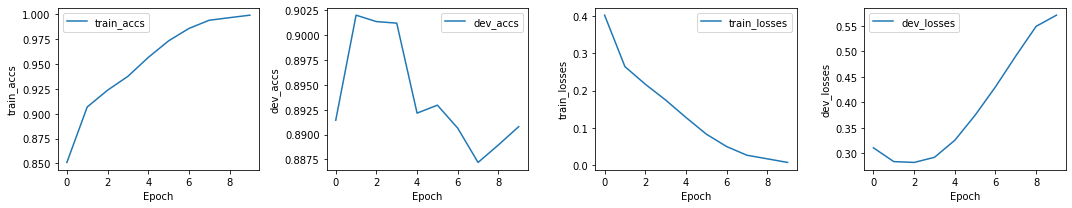

In [22]:
results = dict()
results["train_accs"] = train_accs
results["dev_accs"] = dev_accs
results["train_losses"] = train_losses
results["dev_losses"] = dev_losses
fig, plots = plt.subplots(ncols=4, figsize=(15,3))
for (category, result), plot in zip(results.items(), plots.flatten()):
  plot.plot(result, label=category)
  plot.set_xlabel('Epoch')
  plot.set_ylabel(category)
  plot.legend()
fig.tight_layout()

# test the model

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [26]:
# test the final model with test file
test_csv = pd.read_csv('../data/Davidson/test.csv', names=['label','tweet'], header=0)
X_test = tokenizer(list(test_csv["tweet"]), padding=True, truncation=True, max_length=MAX_SENT_LENGTH)
y_test = list(test_csv["label"])
test_dataset = Dataset(X_dev, y_dev)
test_loader = DataLoader(dataset=dev_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0)
best_model = torch.load("LSTM.model", map_location=DEVICE)
best_model.eval()
preds_list = []
labels_list = []
with torch.no_grad():
    for input_ids, labels in test_loader:
        output = best_model(input_ids)
        preds = torch.argmax(output, dim=1)
        preds_list.extend(preds.cpu())
        labels_list.extend(labels.cpu())


Confusion matrix, without normalization
[[  29   96   25]
 [  24 1842   70]
 [   2   26  364]]


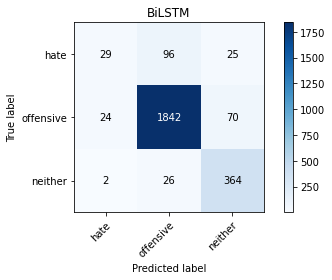

In [27]:
plot_confusion_matrix(labels_list, preds_list, classes = ["hate","offensive","neither"], normalize=False,title='BiLSTM')

Normalized confusion matrix
[[0.19333333 0.64       0.16666667]
 [0.01239669 0.95144628 0.03615702]
 [0.00510204 0.06632653 0.92857143]]


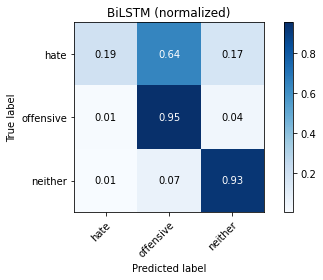

In [28]:
plot_confusion_matrix(labels_list, preds_list, classes = ["hate","offensive","neither"], normalize=True,title='BiLSTM (normalized)')

In [29]:
print(classification_report(labels_list, preds_list, target_names=["hate","offensive","neither"]))

              precision    recall  f1-score   support

        hate       0.53      0.19      0.28       150
   offensive       0.94      0.95      0.94      1936
     neither       0.79      0.93      0.86       392

    accuracy                           0.90      2478
   macro avg       0.75      0.69      0.69      2478
weighted avg       0.89      0.90      0.89      2478

